In [3]:
import numpy as np 
import pandas as pd
import os
import psycopg2
import geopandas as gpd

import importlib
from Secrets import secrets
# importlib.reload(secrets)

import matplotlib.pyplot as plt
import seaborn as sns

### Analysis
 
 - Crime rate over time by category
 - - Areas with most crime rate by type
 - - Crime rate by areas and over time
 
 - Best areas for grocery stores
 - Best areas for going out 
 - Best areas for school catchment
 - Corr/Relationship between areas with most coffee shops/ bars/ restaurants opening and house prices
 
 - Relationship between avg price, gdp, hpi
 - Areas that under and over perform hpi index
 
 - estimate premium paid per sqft for good schools, stores vibrant areas
 - estimate drivers for price

# Crime

In [19]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 
    c.cat_group, g.ward_name, g.ward_geometry, sum(c.value) as total_cases
from crime_by_year as c
join geo2 as g
on c.lsoa = g.lsoa
where c.year = 2019
group by c.cat_group, g.ward_name, g.ward_geometry;
"""

gdf_all = gpd.read_postgis(sql, engine, geom_col='ward_geometry') 
gdf_all.head(2)

# Data below shows the total cases by crime type and wards (geographic region) in London in 2019

,cat_group,ward_name,ward_geometry,total_cases
0,Criminal Damage,Abbey,"POLYGON ((543595.500 184832.800, 543601.700 18...",133.0
1,Criminal Damage,Abbey,"POLYGON ((525122.600 170480.900, 525185.400 17...",52.0


In [39]:
# Top 10 wards and the total crime cases number
gdf_all.groupby("ward_name", as_index=False)["total_cases"].sum().sort_values(by="total_cases", ascending=False).head(10)

,ward_name,total_cases
367,Southwark,38536.0
416,Tower Hamlets,33483.0
178,Hackney,33234.0
104,Croydon,32143.0
447,West End,25636.0
242,Kensington and Chelsea,24067.0
340,Redbridge,23417.0
374,St. James's,21554.0
26,Bexley,17468.0
386,Stratford and New Town,7712.0


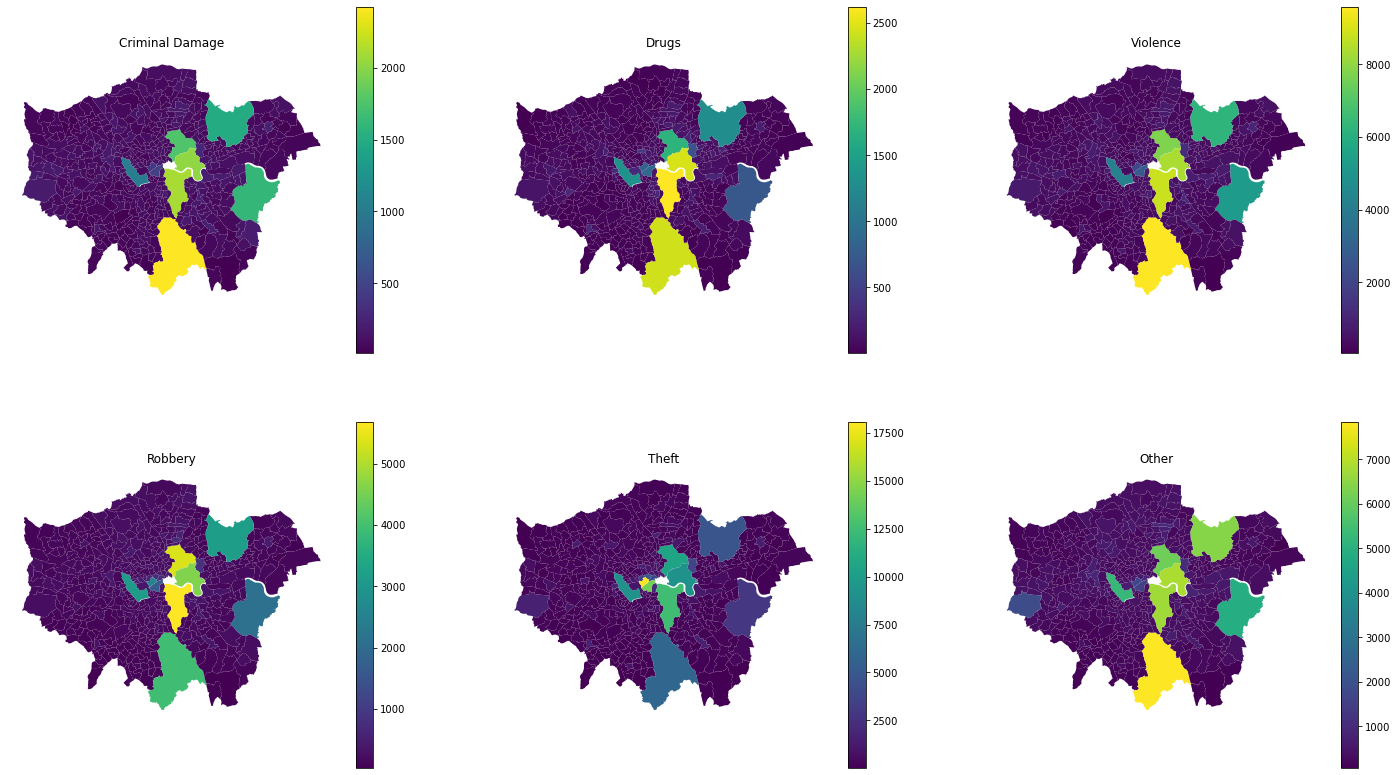

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 14))
ax = ax.flatten()

ax[0].axis('off')
gdf_all[gdf_all.cat_group == "Criminal Damage"].plot(ax = ax[0], column="total_cases", legend=True)
ax[0].set_title("Criminal Damage")

ax[1].axis('off')
gdf_all[gdf_all.cat_group == "Drugs"].plot(ax = ax[1], column="total_cases", legend=True)
ax[1].set_title("Drugs")

ax[2].axis('off')
gdf_all[gdf_all.cat_group == "Violence"].plot(ax = ax[2], column="total_cases", legend=True)
ax[2].set_title("Violence")

ax[3].axis('off')
gdf_all[gdf_all.cat_group == "Robbery"].plot(ax = ax[3], column="total_cases", legend=True)
ax[3].set_title("Robbery")


ax[4].axis('off')
gdf_all[gdf_all.cat_group == "Theft"].plot(ax = ax[4], column="total_cases", legend=True)
ax[4].set_title("Theft")


ax[5].axis('off')
gdf_all[gdf_all.cat_group == "Other"].plot(ax = ax[5], column="total_cases", legend=True)
ax[5].set_title("Other")

plt.show()

# It looks like South and East of London has the most crimes.

In [42]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    c.year, c.cat_group, sum(c.value) as total_cases
from crime_by_year as c
join geo2 as g
on c.lsoa = g.lsoa
group by c.year, c.cat_group;
""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result.head(2)

,year,cat_group,total_cases
0,2008,Criminal Damage,91872.0
1,2008,Drugs,68804.0


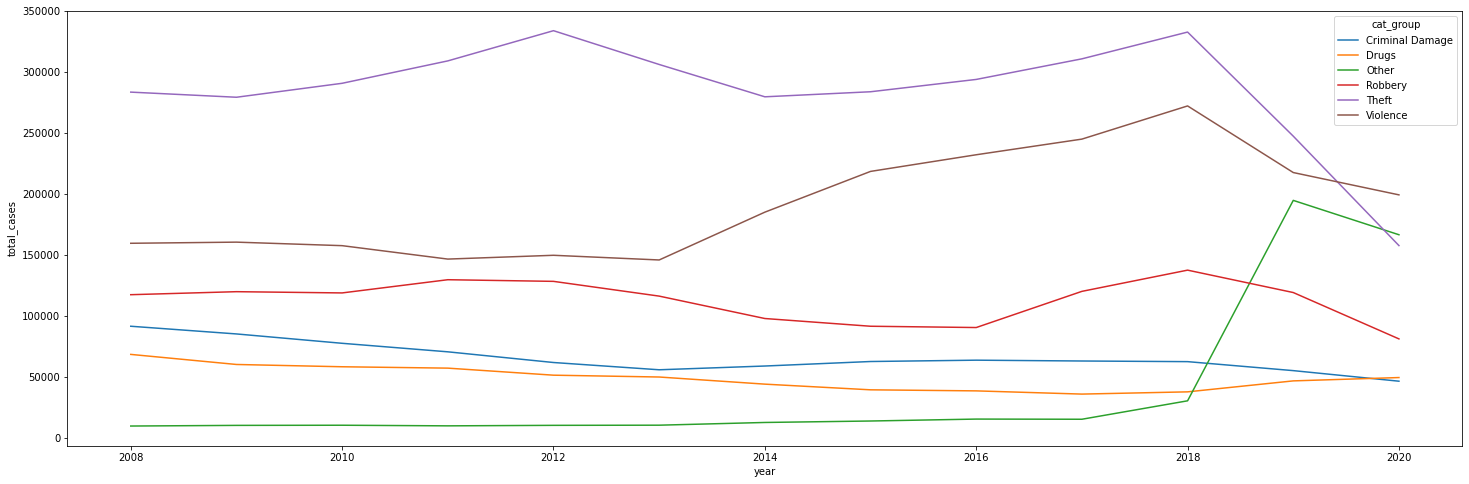

In [44]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.lineplot(data=result, x="year", y="total_cases", hue="cat_group", ax=ax)
plt.show()

# Theft is # 1 crime in London
# Robbery, Theft and violence dropped in 2020, probably due to less people on the streets caused by COVID-19
# There is a sharp increase in Other crime in 2019

In [74]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    c.year, c.cat1, c.cat2, sum(c.value) as total_cases
from crime_by_year as c
join geo2 as g
on c.lsoa = g.lsoa
where c.cat_group = 'Other'
group by c.year,c.cat1, c.cat2;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result.head(2)

,year,cat1,cat2,total_cases
0,2018,Miscellaneous Crimes Against Society,Obscene Publications,165.0
1,2015,Other Notifiable Offences,Other Notifiable,13663.0


In [106]:
result = result.sort_values(by=["year", "cat1", "cat2"])
result["shift"] = result.groupby(["cat1", "cat2"])["total_cases"].shift(1)
result["perc_change"] = (result["total_cases"]/ result["shift"]) -1
result[result["shift"] > 1000].sort_values(by="perc_change", ascending=False).head(5)

# Looks like in 2019 there was 140% increase to vehicle theft crimes
# Interesting to see if it was focused on a specific area

,year,cat1,cat2,total_cases,shift,perc_change
90,2019,Public Order Offences,Public Fear Alarm or Distress,34924.0,2415.0,13.461284
115,2019,Vehicle Offences,Theft from a Motor Vehicle,78163.0,5865.0,12.327025
61,2019,Vehicle Offences,Theft or Taking of a Motor Vehicle,30039.0,2280.0,12.175000
122,2019,Vehicle Offences,Interfering with a Motor Vehicle,16512.0,1305.0,11.652874
26,2014,Other Notifiable Offences,Other Notifiable,12479.0,10229.0,0.219963


In [86]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 
    c.year, c.cat1, c.cat2, concat(g.ward_name, '-', g.rg_name) as ward, g.ward_geometry, sum(c.value) as total_cases
from crime_by_year as c
join geo2 as g
on c.lsoa = g.lsoa
where c.cat_group = 'Other' and c.cat1 in ('Public Order Offences', 'Vehicle Offences')
group by c.year,c.cat1, c.cat2, concat(g.ward_name, '-', g.rg_name) , g.ward_geometry;
"""

gdf_all = gpd.read_postgis(sql, engine, geom_col='ward_geometry') 

gdf_all.head(2)

,year,cat1,cat2,ward,ward_geometry,total_cases
0,2018,Public Order Offences,"Other Offences Against the State, or Public Order",Abbey-Barking and Dagenham,"POLYGON ((543595.500 184832.800, 543601.700 18...",1.0
1,2018,Public Order Offences,"Other Offences Against the State, or Public Order",Abbey-Merton,"POLYGON ((525122.600 170480.900, 525185.400 17...",4.0


In [107]:
# gdf_all = gdf_all.sort_values(by=["year", "cat1", "cat2", "ward"])
# gdf_all["shift1"] = gdf_all.groupby(["cat1", "cat2", "ward"])["total_cases"].shift(1)
gdf_all["perc_change"] = (gdf_all["total_cases"]/ gdf_all["shift1"] ) -1
# filter by areas where prev year # of cases is around mean to avoid large increase dues to no cases in prev years
gdf_all = gdf_all[gdf_all["shift1"] > 30].sort_values(by="perc_change", ascending=False)
gdf_all.head()

,year,cat1,cat2,ward,ward_geometry,total_cases,shift1,perc_change,perc_change_bins
6799,2019,Vehicle Offences,Theft or Taking of a Motor Vehicle,Southwark-Southwark,"POLYGON ((531335.600 180529.500, 531337.700 18...",1089.0,52.0,19.942308,1000%+
6606,2019,Vehicle Offences,Theft or Taking of a Motor Vehicle,Hackney-Hackney,"POLYGON ((531928.400 187801.500, 531935.700 18...",825.0,50.0,15.500000,1000%+
5869,2019,Vehicle Offences,Interfering with a Motor Vehicle,Tower Hamlets-Tower Hamlets,"POLYGON ((533387.600 180516.400, 533389.800 18...",614.0,38.0,15.157895,1000%+
6771,2019,Vehicle Offences,Theft or Taking of a Motor Vehicle,Redbridge-Redbridge,"POLYGON ((543595.500 184832.800, 543577.100 18...",1366.0,86.0,14.883721,1000%+
4054,2019,Public Order Offences,Public Fear Alarm or Distress,Croydon-Croydon,"POLYGON ((535009.200 159504.700, 535005.500 15...",1324.0,84.0,14.761905,1000%+


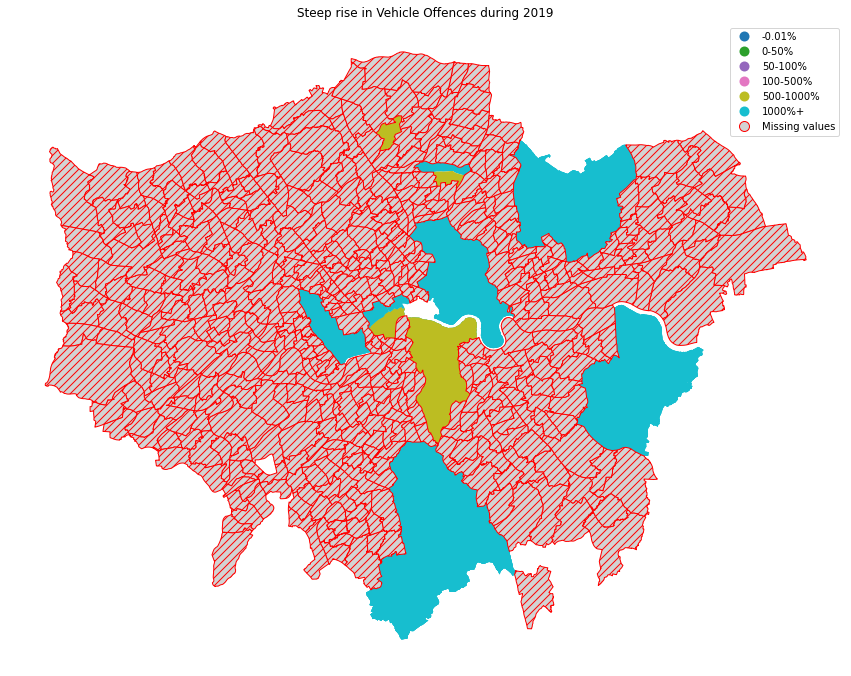

In [118]:
# Group count for better visualization
gdf_all["perc_change_bins"] = pd.cut(gdf_all["perc_change"], [-1 , 0, 0.5, 1, 5, 10, 50],labels=["-0.01%", "0-50%", "50-100%", "100-500%", "500-1000%", "1000%+"])

fig, ax = plt.subplots(figsize=(15, 14))
ax.axis('off')
# Merged back the complete geometry dataset to ensure the wards with no crime are also shown
gdf_all[["ward_geometry"]].drop_duplicates().merge(gdf_all[ (gdf_all.year == 2019)], \
                                                   how="left", on="ward_geometry").plot(ax = ax, \
                                                                                        column="perc_change_bins", legend=True, missing_kwds={"color": "lightgrey",\
                                                                                                                                            "edgecolor": "red",  \
                                                                                                                                            "hatch": "///",\
                                                                                                                                            "label": "Missing values",})
ax.set_title("Steep rise in Vehicle Offences during 2019")
plt.show()

# Grocery stores

In [ ]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 
    s.lsoa, s.cat_group, g.rg_name, g.lsoa_geometry, count(*) as total_stores
from stores as s
join geo2 as g
on c.lsoa = g.lsoa
group by s.lsoa, s.cat_group, g.rg_name, g.lsoa_geometry,
;

"""

gdf_all = gpd.read_postgis(sql, engine, geom_col='ward_geometry') 
gdf_all.head(2)

In [ ]:
# Schools

In [ ]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 
    s.lsoa, s.cat_group, g.rg_name, g.lsoa_geometry, count(*) as total_stores
from schools as s
join geo2 as g
on c.lsoa = g.lsoa
group by s.lsoa, s.cat_group, g.rg_name, g.lsoa_geometry,
;

"""

gdf_all = gpd.read_postgis(sql, engine, geom_col='ward_geometry') 
gdf_all.head(2)

In [ ]:
# Choose comparable properties

In [ ]:
# Correlation between prices and # of coffee shops by lsoa


In [ ]:
# # Get Data from AWS RDS PostgresSQL DB (all data within the database is publicly available and been scrapped and collected by myself)

# engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
# cur = engine.cursor()

# cur.execute("""

# SELECT 
#     CAST (p.year AS INTEGER), p.new, p.duration, p.type, g.rg_name, g.geometry,
#     CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price,
#     CAST(ROUND(AVG(e.total_floor_area)::numeric,0 ) as integer) as avg_sqft,
#     CAST(ROUND(AVG(e.number_habitable_rooms)::numeric,0 ) as integer) as avg_rooms,
#     CAST(ROUND( AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price,
#     CAST(ROUND( AVG(p.price/e.number_habitable_rooms)::numeric, 3 ) as integer) as price_per_room

# from prices as p
# join epc as e
# on e.brn = p.brn
# join geo as g
# on p.lsoa = g.lsoa
# where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null

# group by p.year, p.new, p.duration, p.type, g.rg_name, g.geometry;

# """)
# rows = cur.fetchall()
# result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
# result.head(2)

In [ ]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """

select g.lsoa, g.lsoa_name, g.geometry, avg(p.price)
from geo as g
left join prices2 as p
on p.lsoa = g.lsoa
group by g.lsoa, g.geometry, g.lsoa_name;

"""

gdf = gpd.read_postgis(sql, engine, geom_col='geometry') 
gdf

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
ax.axis('off')
gdf.plot(ax = ax, column="avg", \
         legend=True, \
         missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Missing values",},
        )

plt.show()